# Multivariate LSTM Time Series Stock Prediction - NASDAQ Comp

Stock Prediction of NASDAQ Comp using LSTM with multiple features.

**Data source:** Yahoo Finance via `yfinance`

**Features:** NASDAQ Comp Close, Daily % Change of 18 NASDAQ Comp components, US Treasury Yield
>`^IXIC_Close`, `^IXIC_%_Daily_Change`, `^DJI_%_Daily_Change`,
               `^GSPC_%_Daily_Change`, `AAPL_%_Daily_Change`, `MSFT_%_Daily_Change`,
               `AMZN_%_Daily_Change`, `FB_%_Daily_Change`, `GOOG_%_Daily_Change`,
               `GOOGL_%_Daily_Change`, `TSLA_%_Daily_Change`, `NVDA_%_Daily_Change`,
               `ASML_%_Daily_Change`, `INTC_%_Daily_Change`, `CMCSA_%_Daily_Change`,
               `NFLX_%_Daily_Change`, `ADBE_%_Daily_Change`, `CSCO_%_Daily_Change`,
               `PEP_%_Daily_Change`, `AVGO_%_Daily_Change`, `TXN_%_Daily_Change`,
               `TMUS_%_Daily_Change`, `^IRX_%_Daily_Change`, `^FVX_%_Daily_Change`,
               `^TNX_%_Daily_Change`, `^TYX_%_Daily_Change`

**Train/Test:** 0.90 / 0.10

**Reference:** https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/#h-implementing-a-multivariate-time-series-prediction-model-in-python

### Setup

In [24]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training

# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

import seaborn as sns

In [ ]:
#!pip install tensorflow

In [ ]:
# !pip install yfinance

### Step #1 Load the Time Series Data from yfinance


In [2]:
# import pandas as pd
# import seaborn as sns
# import numpy as np
import random
import re
# import matplotlib.pyplot as plt
from datetime import date

plt.rcParams['figure.figsize'] = (20, 12) 
import yfinance as yf
pd.set_option('display.max_columns', 500)

In [3]:
def dpna(x):
    x.dropna(inplace=True)
    x.reset_index(drop=True,inplace=True)
    return x

def dr(x):
    drp=[]
    yes=[]
    #x['Open'].astype(float)
    for i in range(len(x['Open'])): 
            
        if i>0:
            drp.append((x['Open'][i]-x['Open'][i-1])/x['Open'][i-1]*100)
            if (x['Open'][i]-x['Open'][i-1])>0:
                yes.append(1)
            else:
                yes.append(0)
        else:
            drp.append(0)
            yes.append(np.nan)

    x['%_Daily_Return']=drp
    x['Yesterday_Price_Change']=yes  
        
    return x


def tr(x):
    dc=[]
    dcp=[]
    tmr=[]
    for i in range(len(x['Open'])): 
            
        if i!=(len(x['Open'])-1):
            dcp.append((x['Close'][i]-x['Open'][i])/x['Open'][i])
            if (x['Close'][i]-x['Open'][i])>0:
                dc.append(1)   
            else:
                dc.append(0)
            if (x['Close'][i+1]-x['Close'][i])>0:
                tmr.append(1)
            else:
                tmr.append(0)
                
        else:
            dcp.append(np.nan)
            dc.append(np.nan)
            tmr.append(np.nan)
        
    x['%_Daily_Change']=dcp
    x['Daily_Change']=dc
    x['tmr_Change']=tmr
        
        
    return x

In [4]:
#NASDAQ Composite (^IXIC), Dow Jones =DJI, S&P500=GSPC, 13 Week Treasury Bill (^IRX), Treasury Yield 5 Years (^FVX), Treasury Yield 10 Years (^TNX), Treasury Yield 30 Years (^TYX)

Index=['^IXIC','^DJI','^GSPC']
Stock=['AAPL','MSFT','AMZN','FB','GOOG','GOOGL','TSLA','NVDA','ASML','INTC','CMCSA','NFLX','ADBE','CSCO','PEP','AVGO','TXN','TMUS']
Bond=['^IRX','^FVX','^TNX','^TYX']
Currency=['CNY=X','GBP=X','JPY=X','EUR=X','CAD=X']
col_list=Index+Stock+Bond+Currency

df=pd.DataFrame()

for i in col_list:
    data = yf.download(i, start="2013-01-01")
    data=dr(data)
    data=tr(data)
    col1_list=[i+'_'+j for j in data.columns]
    data.columns=col1_list
    data=data.loc[:, (data != 0.0).any(axis=0)]
    
    df=df=pd.DataFrame().join([df,data], how="outer")


#df.dropna(axis=0,inplace=True)
#df.reset_index(drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
df.reset_index(inplace=True)

In [6]:
df.Date=pd.to_datetime(df.Date)
df['DayOfWeek']=df['Date'].apply(lambda x:x.strftime('%w'))
df['Year']=df['Date'].apply(lambda x:x.strftime('%Y'))
df['Month']=df['Date'].apply(lambda x:x.strftime('%m'))

In [8]:
df.dropna(inplace=True)
df

,Date,^IXIC_Open,^IXIC_High,^IXIC_Low,^IXIC_Close,^IXIC_Adj Close,^IXIC_Volume,^IXIC_%_Daily_Return,^IXIC_Yesterday_Price_Change,^IXIC_%_Daily_Change,^IXIC_Daily_Change,^IXIC_tmr_Change,^DJI_Open,^DJI_High,^DJI_Low,^DJI_Close,^DJI_Adj Close,^DJI_Volume,^DJI_%_Daily_Return,^DJI_Yesterday_Price_Change,^DJI_%_Daily_Change,^DJI_Daily_Change,^DJI_tmr_Change,^GSPC_Open,^GSPC_High,^GSPC_Low,^GSPC_Close,^GSPC_Adj Close,^GSPC_Volume,^GSPC_%_Daily_Return,^GSPC_Yesterday_Price_Change,^GSPC_%_Daily_Change,^GSPC_Daily_Change,^GSPC_tmr_Change,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AAPL_%_Daily_Return,AAPL_Yesterday_Price_Change,AAPL_%_Daily_Change,AAPL_Daily_Change,AAPL_tmr_Change,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,MSFT_%_Daily_Return,MSFT_Yesterday_Price_Change,MSFT_%_Daily_Change,MSFT_Daily_Change,MSFT_tmr_Change,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,AMZN_%_Daily_Return,AMZN_Yesterday_Price_Change,AMZN_%_Daily_Change,AMZN_Daily_Change,AMZN_tmr_Change,FB_Open,FB_High,FB_Low,FB_Close,FB_Adj Close,FB_Volume,FB_%_Daily_Return,FB_Yesterday_Price_Change,FB_%_Daily_Change,FB_Daily_Change,FB_tmr_Change,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,GOOG_%_Daily_Return,GOOG_Yesterday_Price_Change,GOOG_%_Daily_Change,GOOG_Daily_Change,GOOG_tmr_Change,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,GOOGL_%_Daily_Return,GOOGL_Yesterday_Price_Change,GOOGL_%_Daily_Change,GOOGL_Daily_Change,GOOGL_tmr_Change,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,TSLA_%_Daily_Return,TSLA_Yesterday_Price_Change,TSLA_%_Daily_Change,TSLA_Daily_Change,TSLA_tmr_Change,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,NVDA_%_Daily_Return,NVDA_Yesterday_Price_Change,NVDA_%_Daily_Change,NVDA_Daily_Change,NVDA_tmr_Change,ASML_Open,ASML_High,ASML_Low,ASML_Close,ASML_Adj Close,ASML_Volume,ASML_%_Daily_Return,ASML_Yesterday_Price_Change,ASML_%_Daily_Change,ASML_Daily_Change,ASML_tmr_Change,INTC_Open,INTC_High,INTC_Low,INTC_Close,INTC_Adj Close,INTC_Volume,INTC_%_Daily_Return,INTC_Yesterday_Price_Change,INTC_%_Daily_Change,INTC_Daily_Change,INTC_tmr_Change,CMCSA_Open,CMCSA_High,CMCSA_Low,CMCSA_Close,CMCSA_Adj Close,CMCSA_Volume,CMCSA_%_Daily_Return,CMCSA_Yesterday_Price_Change,CMCSA_%_Daily_Change,CMCSA_Daily_Change,CMCSA_tmr_Change,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,NFLX_%_Daily_Return,NFLX_Yesterday_Price_Change,NFLX_%_Daily_Change,NFLX_Daily_Change,NFLX_tmr_Change,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,ADBE_%_Daily_Return,ADBE_Yesterday_Price_Change,ADBE_%_Daily_Change,ADBE_Daily_Change,ADBE_tmr_Change,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,CSCO_%_Daily_Return,CSCO_Yesterday_Price_Change,CSCO_%_Daily_Change,CSCO_Daily_Change,CSCO_tmr_Change,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,PEP_%_Daily_Return,PEP_Yesterday_Price_Change,PEP_%_Daily_Change,PEP_Daily_Change,PEP_tmr_Change,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,AVGO_%_Daily_Return,AVGO_Yesterday_Price_Change,AVGO_%_Daily_Change,AVGO_Daily_Change,AVGO_tmr_Change,TXN_Open,TXN_High,TXN_Low,TXN_Close,TXN_Adj Close,TXN_Volume,TXN_%_Daily_Return,TXN_Yesterday_Price_Change,TXN_%_Daily_Change,TXN_Daily_Change,TXN_tmr_Change,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,TMUS_%_Daily_Return,TMUS_Yesterday_Price_Change,TMUS_%_Daily_Change,TMUS_Daily_Change,TMUS_tmr_Change,^IRX_Open,^IRX_High,^IRX_Low,^IRX_Close,^IRX_Adj Close,^IRX_%_Daily_Return,^IRX_Yesterday_Price_Change,^IRX_%_Daily_Change,^IRX_Daily_Change,^IRX_tmr_Change,^FVX_Open,^FVX_High,^FVX_Low,^FVX_Close,^FVX_Adj Close,^FVX_%_Daily_Return,^FVX_Yesterday_Price_Change,^FVX_%_Daily_Change,^FVX_Daily_Change,^FVX_tmr_Change,^TNX_Open,^TNX_High,^TNX_Low,^TNX_Close,^TNX_Adj Close,^TNX_%_Daily_Return,^TNX_Yesterday_Price_Change,^TNX_%_Daily_Change,^TNX_Dai

In [9]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 2 to 2383
Data columns (total 325 columns):
 #    Column                        Non-Null Count  Dtype         
---   ------                        --------------  -----         
 0    Date                          2293 non-null   datetime64[ns]
 1    ^IXIC_Open                    2293 non-null   float64       
 2    ^IXIC_High                    2293 non-null   float64       
 3    ^IXIC_Low                     2293 non-null   float64       
 4    ^IXIC_Close                   2293 non-null   float64       
 5    ^IXIC_Adj Close               2293 non-null   float64       
 6    ^IXIC_Volume                  2293 non-null   float64       
 7    ^IXIC_%_Daily_Return          2293 non-null   float64       
 8    ^IXIC_Yesterday_Price_Change  2293 non-null   float64       
 9    ^IXIC_%_Daily_Change          2293 non-null   float64       
 10   ^IXIC_Daily_Change            2293 non-null   float64       
 11   ^IXIC_tmr_Chang

/var/folders/71/1sps22qj5w32ftm713lpq5200000gn/T/ipykernel_26455/2728897127.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True,null_counts=True)


In [ ]:
# Close = pd.concat([df.filter(items=['Date']), df.filter(regex=r'\_Close$', axis=1)], axis=1)
# Close = Close.set_index("Date")
# Close = Close.drop(columns = ['CNY=X_Close','GBP=X_Close','JPY=X_Close','EUR=X_Close','CAD=X_Close'])
# Close.head()

In [10]:
Close = pd.concat([df.filter(items=['Date']), df['^IXIC_Close'], df.filter(regex=r'\_%_Daily_Change$', axis=1)], axis=1)
Close = Close.set_index("Date")
Close = Close.drop(columns = ['CNY=X_%_Daily_Change','GBP=X_%_Daily_Change',
                              'JPY=X_%_Daily_Change','EUR=X_%_Daily_Change','CAD=X_%_Daily_Change'])
Close.head()

,^IXIC_Close,^IXIC_%_Daily_Change,^DJI_%_Daily_Change,^GSPC_%_Daily_Change,AAPL_%_Daily_Change,MSFT_%_Daily_Change,AMZN_%_Daily_Change,FB_%_Daily_Change,GOOG_%_Daily_Change,GOOGL_%_Daily_Change,TSLA_%_Daily_Change,NVDA_%_Daily_Change,ASML_%_Daily_Change,INTC_%_Daily_Change,CMCSA_%_Daily_Change,NFLX_%_Daily_Change,ADBE_%_Daily_Change,CSCO_%_Daily_Change,PEP_%_Daily_Change,AVGO_%_Daily_Change,TXN_%_Daily_Change,TMUS_%_Daily_Change,^IRX_%_Daily_Change,^FVX_%_Daily_Change,^TNX_%_Daily_Change,^TYX_%_Daily_Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,3112.260010,0.006771,0.023523,0.025403,-0.008649,0.013578,0.004803,0.020408,0.005324,0.005324,0.010286,0.012739,0.012125,0.010875,0.012352,-0.033610,0.011076,0.010934,0.002168,0.003392,0.024089,-0.030000,0.057692,-0.021795,-0.001629,0.000986
2013-01-03,3100.570068,-0.002548,-0.001614,-0.002086,-0.010550,-0.013753,0.004703,-0.003945,-0.001738,-0.001738,-0.011654,0.000786,-0.009244,-0.003738,-0.010392,0.050234,-0.010225,-0.000489,0.001155,0.011441,-0.008087,-0.009259,0.000000,0.050715,0.029827,0.020361
2013-01-04,3101.659912,0.000252,0.003298,0.004865,-0.018567,-0.019435,0.006095,0.026776,0.011833,0.011833,-0.011494,0.031373,0.001083,-0.009363,-0.003403,-0.005801,0.006600,0.003430,0.002453,-0.006116,-0.005625,0.010384,-0.071429,-0.036471,-0.018955,-0.015195
2013-01-07,3098.810059,0.003121,-0.003858,-0.003123,0.003640,-0.002988,0.020877,0.025444,-0.000952,-0.000952,-0.013218,-0.028158,0.004893,-0.001410,0.001321,0.029152,0.003438,-0.004416,-0.001151,-0.001545,0.004721,-0.001045,-0.107692,0.002466,-0.000525,-0.000645
2013-01-08,3091.810059,-0.002146,-0.003631,-0.003242,-0.007369,-0.007477,-0.002584,-0.015249,-0.003045,-0.003045,-0.023768,-0.024219,-0.004101,-0.006594,0.011665,-0.028497,0.009529,0.006442,0.005921,-0.010786,-0.006299,-0.018927,-0.076923,-0.029666,-0.012144,-0.006149


### Step #2 Explore the Data


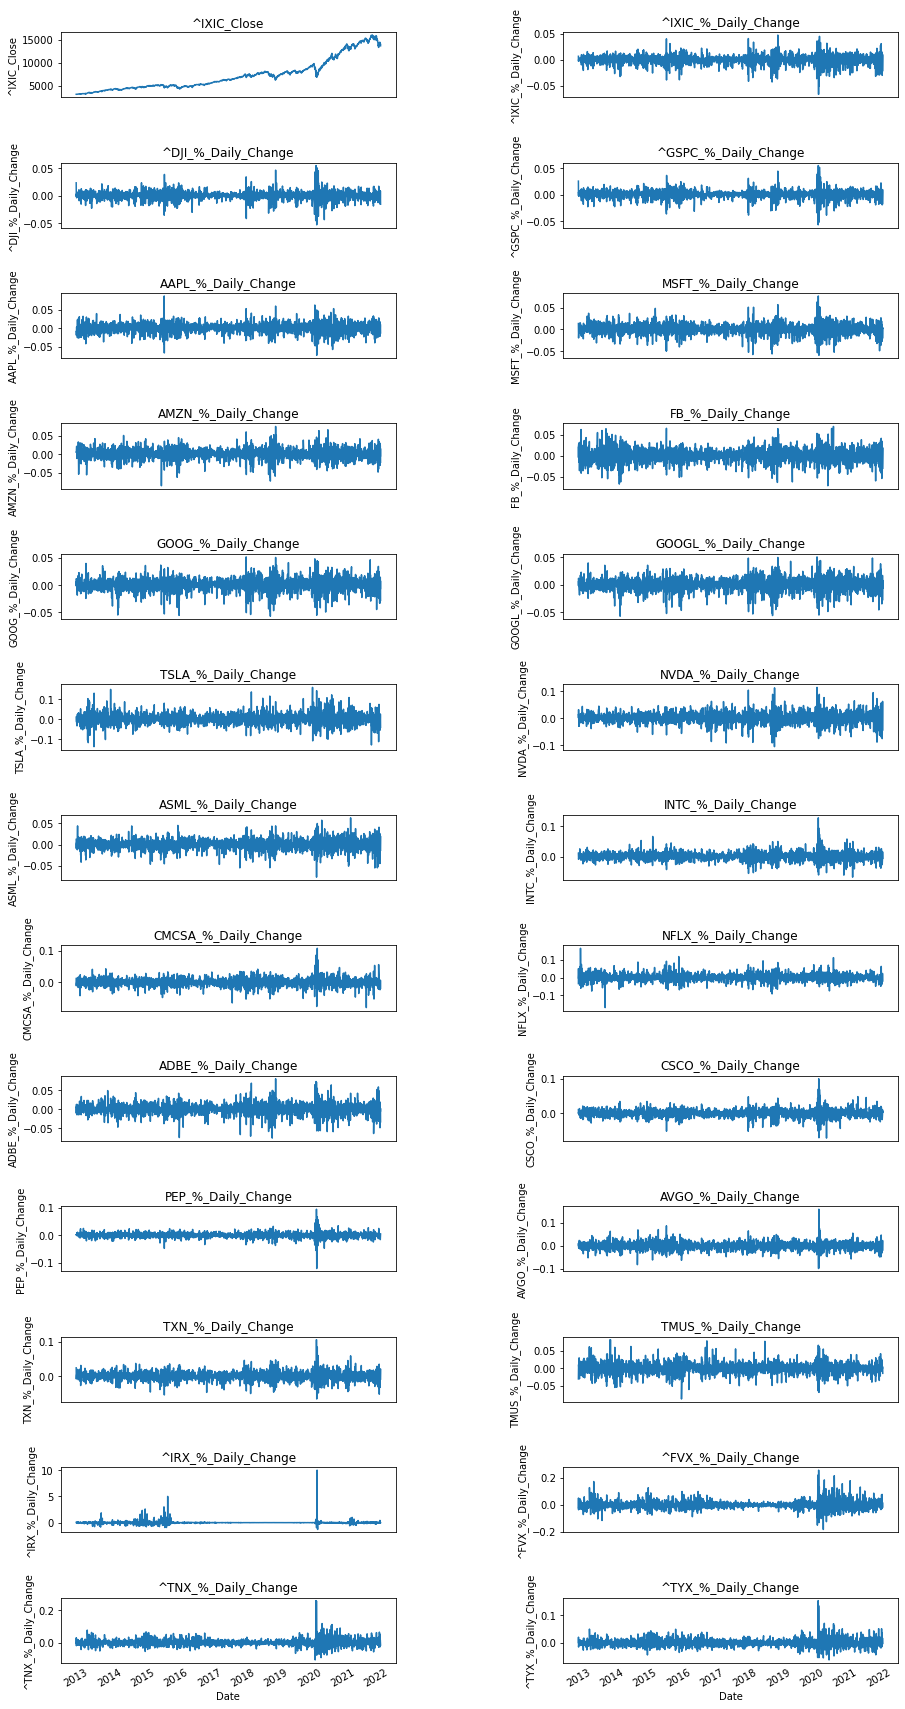

In [12]:
# Plot line charts
Close_plot = Close.copy()

list_length = Close_plot.shape[1]
ncols = 2
nrows = int(round(list_length // ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 30))
fig.subplots_adjust(hspace=1, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = Close.iloc[:, i], ax=ax)
        ax.set_title(Close.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# fig.tight_layout()
plt.show()

### Step #3 Scaling and Feature Selection

In [13]:
# Indexing Batches
train_df = Close.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,^IXIC_Close,^IXIC_%_Daily_Change,^DJI_%_Daily_Change,^GSPC_%_Daily_Change,AAPL_%_Daily_Change,MSFT_%_Daily_Change,AMZN_%_Daily_Change,FB_%_Daily_Change,GOOG_%_Daily_Change,GOOGL_%_Daily_Change,TSLA_%_Daily_Change,NVDA_%_Daily_Change,ASML_%_Daily_Change,INTC_%_Daily_Change,CMCSA_%_Daily_Change,NFLX_%_Daily_Change,ADBE_%_Daily_Change,CSCO_%_Daily_Change,PEP_%_Daily_Change,AVGO_%_Daily_Change,TXN_%_Daily_Change,TMUS_%_Daily_Change,^IRX_%_Daily_Change,^FVX_%_Daily_Change,^TNX_%_Daily_Change,^TYX_%_Daily_Change,Month,Year
0,3112.260010,0.006771,0.023523,0.025403,-0.008649,0.013578,0.004803,0.020408,0.005324,0.005324,0.010286,0.012739,0.012125,0.010875,0.012352,-0.033610,0.011076,0.010934,0.002168,0.003392,0.024089,-0.030000,0.057692,-0.021795,-0.001629,0.000986,01,2013
1,3100.570068,-0.002548,-0.001614,-0.002086,-0.010550,-0.013753,0.004703,-0.003945,-0.001738,-0.001738,-0.011654,0.000786,-0.009244,-0.003738,-0.010392,0.050234,-0.010225,-0.000489,0.001155,0.011441,-0.008087,-0.009259,0.000000,0.050715,0.029827,0.020361,01,2013
2,3101.659912,0.000252,0.003298,0.004865,-0.018567,-0.019435,0.006095,0.026776,0.011833,0.011833,-0.011494,0.031373,0.001083,-0.009363,-0.003403,-0.005801,0.006600,0.003430,0.002453,-0.006116,-0.005625,0.010384,-0.071429,-0.036471,-0.018955,-0.015195,01,2013
3,3098.810059,0.003121,-0.003858,-0.003123,0.003640,-0.002988,0.020877,0.025444,-0.000952,-0.000952,-0.013218,-0.028158,0.004893,-0.001410,0.001321,0.029152,0.003438,-0.004416,-0.001151,-0.001545,0.004721,-0.001045,-0.107692,0.002466,-0.000525,-0.000645,01,2013
4,3091.810059,-0.002146,-0.003631,-0.003242,-0.007369,-0.007477,-0.002584,-0.015249,-0.003045,-0.003045,-0.023768,-0.024219,-0.004101,-0.006594,0.011665,-0.028497,0.009529,0.006442,0.005921,-0.010786,-0.006299,-0.018927,-0.076923,-0.029666,-0.012144,-0.006149,01,2013


In [14]:
train_df.columns

Index(['^IXIC_Close', '^IXIC_%_Daily_Change', '^DJI_%_Daily_Change',
       '^GSPC_%_Daily_Change', 'AAPL_%_Daily_Change', 'MSFT_%_Daily_Change',
       'AMZN_%_Daily_Change', 'FB_%_Daily_Change', 'GOOG_%_Daily_Change',
       'GOOGL_%_Daily_Change', 'TSLA_%_Daily_Change', 'NVDA_%_Daily_Change',
       'ASML_%_Daily_Change', 'INTC_%_Daily_Change', 'CMCSA_%_Daily_Change',
       'NFLX_%_Daily_Change', 'ADBE_%_Daily_Change', 'CSCO_%_Daily_Change',
       'PEP_%_Daily_Change', 'AVGO_%_Daily_Change', 'TXN_%_Daily_Change',
       'TMUS_%_Daily_Change', '^IRX_%_Daily_Change', '^FVX_%_Daily_Change',
       '^TNX_%_Daily_Change', '^TYX_%_Daily_Change', 'Month', 'Year'],
      dtype='object')

In [15]:
# List of considered Features
FEATURES = ['^IXIC_Close', '^IXIC_%_Daily_Change', '^DJI_%_Daily_Change',
       '^GSPC_%_Daily_Change', 'AAPL_%_Daily_Change', 'MSFT_%_Daily_Change',
       'AMZN_%_Daily_Change', 'FB_%_Daily_Change', 'GOOG_%_Daily_Change',
       'GOOGL_%_Daily_Change', 'TSLA_%_Daily_Change', 'NVDA_%_Daily_Change',
       'ASML_%_Daily_Change', 'INTC_%_Daily_Change', 'CMCSA_%_Daily_Change',
       'NFLX_%_Daily_Change', 'ADBE_%_Daily_Change', 'CSCO_%_Daily_Change',
       'PEP_%_Daily_Change', 'AVGO_%_Daily_Change', 'TXN_%_Daily_Change',
       'TMUS_%_Daily_Change', '^IRX_%_Daily_Change', '^FVX_%_Daily_Change',
       '^TNX_%_Daily_Change', '^TYX_%_Daily_Change']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['^IXIC_Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['^IXIC_Close', '^IXIC_%_Daily_Change', '^DJI_%_Daily_Change', '^GSPC_%_Daily_Change', 'AAPL_%_Daily_Change', 'MSFT_%_Daily_Change', 'AMZN_%_Daily_Change', 'FB_%_Daily_Change', 'GOOG_%_Daily_Change', 'GOOGL_%_Daily_Change', 'TSLA_%_Daily_Change', 'NVDA_%_Daily_Change', 'ASML_%_Daily_Change', 'INTC_%_Daily_Change', 'CMCSA_%_Daily_Change', 'NFLX_%_Daily_Change', 'ADBE_%_Daily_Change', 'CSCO_%_Daily_Change', 'PEP_%_Daily_Change', 'AVGO_%_Daily_Change', 'TXN_%_Daily_Change', 'TMUS_%_Daily_Change', '^IRX_%_Daily_Change', '^FVX_%_Daily_Change', '^TNX_%_Daily_Change', '^TYX_%_Daily_Change']


,^IXIC_Close,^IXIC_%_Daily_Change,^DJI_%_Daily_Change,^GSPC_%_Daily_Change,AAPL_%_Daily_Change,MSFT_%_Daily_Change,AMZN_%_Daily_Change,FB_%_Daily_Change,GOOG_%_Daily_Change,GOOGL_%_Daily_Change,TSLA_%_Daily_Change,NVDA_%_Daily_Change,ASML_%_Daily_Change,INTC_%_Daily_Change,CMCSA_%_Daily_Change,NFLX_%_Daily_Change,ADBE_%_Daily_Change,CSCO_%_Daily_Change,PEP_%_Daily_Change,AVGO_%_Daily_Change,TXN_%_Daily_Change,TMUS_%_Daily_Change,^IRX_%_Daily_Change,^FVX_%_Daily_Change,^TNX_%_Daily_Change,^TYX_%_Daily_Change,Prediction
2288,13791.150391,-0.029723,-0.015023,-0.019446,-0.021412,-0.026881,-0.030613,-0.039000,-0.033297,-0.031151,-0.054561,-0.075899,-0.044560,-0.026966,-0.022979,-0.034589,-0.048100,-0.017678,0.003094,-0.030337,-0.032543,-0.001684,-0.093834,-0.027083,-0.025909,-0.013549,13791.150391
2289,13790.919922,0.001594,-0.003699,-0.002479,0.009022,0.004187,0.022511,-0.007341,0.014505,0.017031,0.016470,0.013913,0.002811,-0.007095,-0.014553,0.023169,0.001712,-0.004306,-0.016055,0.006226,-0.008967,-0.001035,0.014085,0.017507,0.016811,0.017241,13790.919922
2290,14139.759766,0.010186,0.008725,0.009435,0.010645,0.001533,-0.006948,0.002404,-0.007609,-0.006993,0.024922,0.061966,0.013792,0.015514,0.007126,0.009089,-0.006279,0.010238,-0.007535,0.023326,0.008252,0.004666,-0.036145,-0.001033,0.005903,0.011997,14139.759766
2291,14124.089844,0.006067,-0.000502,0.004322,0.004073,0.003787,0.014828,0.019443,0.007747,0.007988,0.010218,0.009597,0.019754,0.003537,0.003548,-0.008592,0.002539,0.002217,0.004045,0.005303,0.020936,-0.000314,-0.079012,-0.003633,0.005897,0.009390,14124.089844
2292,13716.719727,-0.020527,-0.015676,-0.017011,-0.012571,-0.018997,-0.022090,-0.029483,-0.028215,-0.027187,-0.040416,-0.043816,-0.013469,-0.006059,-0.018262,-0.019201,-0.032612,0.004865,0.004458,-0.018145,-0.008551,-0.014168,-0.041667,-0.015974,-0.014985,-0.002158,13716.719727


In [16]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['^IXIC_Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2293, 26)


### Step #4 Transforming the Data

In [17]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

In [18]:
# Prediction Index
index_Close = data.columns.get_loc("^IXIC_Close")

In [19]:
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 90% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2014, 50, 26) (2014,)
(229, 50, 26) (229,)
0.012128990667220396
0.012128990667220396


### Step #5 Train the Multivariate Prediction Model

In [20]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

2022-02-20 14:36:37.243784: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1300 50 26


In [21]:
# Training the model
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),

                    callbacks=[early_stop])

Epoch 1/10
126/126 [==============================] - 1042s 8s/step - loss: 0.5352 - val_loss: 0.0016
Epoch 2/10
126/126 [==============================] - 809s 6s/step - loss: 8.1977e-04 - val_loss: 0.0013
Epoch 3/10
126/126 [==============================] - 885s 7s/step - loss: 4.9869e-04 - val_loss: 0.0011
Epoch 4/10
126/126 [==============================] - 891s 7s/step - loss: 3.4331e-04 - val_loss: 0.0012
Epoch 5/10
126/126 [==============================] - 1048s 8s/step - loss: 2.9017e-04 - val_loss: 0.0010
Epoch 6/10
126/126 [==============================] - 977s 8s/step - loss: 3.0366e-04 - val_loss: 0.0011
Epoch 7/10
126/126 [==============================] - 797s 6s/step - loss: 2.1111e-04 - val_loss: 6.2922e-04
Epoch 8/10
126/126 [==============================] - 789s 6s/step - loss: 2.0357e-04 - val_loss: 6.2352e-04
Epoch 9/10
126/126 [==============================] - 897s 7s/step - loss: 1.7741e-04 - val_loss: 0.0013
Epoch 10/10
126/126 [============================

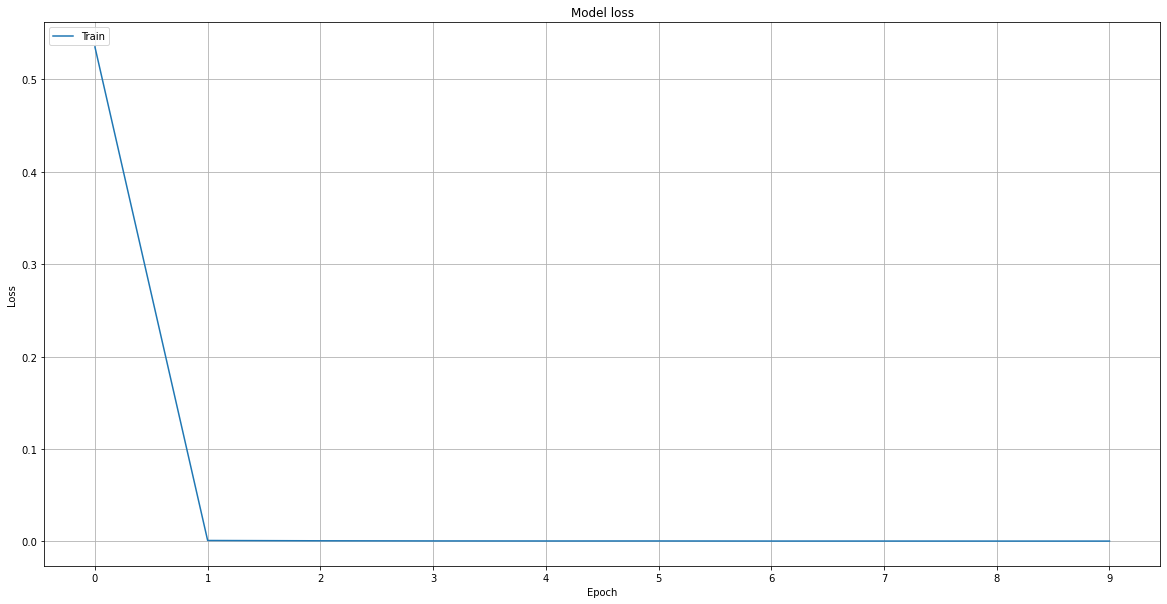

In [22]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

### Step #6 Evaluate Model Performance

In [66]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

#r2 Score
R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2 Score: {np.round(R2, 2)}')

Mean Absolute Error (MAE): 202.06
Mean Absolute Percentage Error (MAPE): 1.4 %
Median Absolute Percentage Error (MDAPE): 0.99 %
R2 Score: 0.87


In [56]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=3287)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["^IXIC_Close"], True)

In [53]:
train.to_csv('Multivariate Time Series Prediction_NASDAQ_Close w Daily Change_ 0.9-0.1_train.csv')

In [54]:
valid.to_csv('Multivariate Time Series Prediction_NASDAQ_Close w Daily Change_ 0.9-0.1_valid.csv')

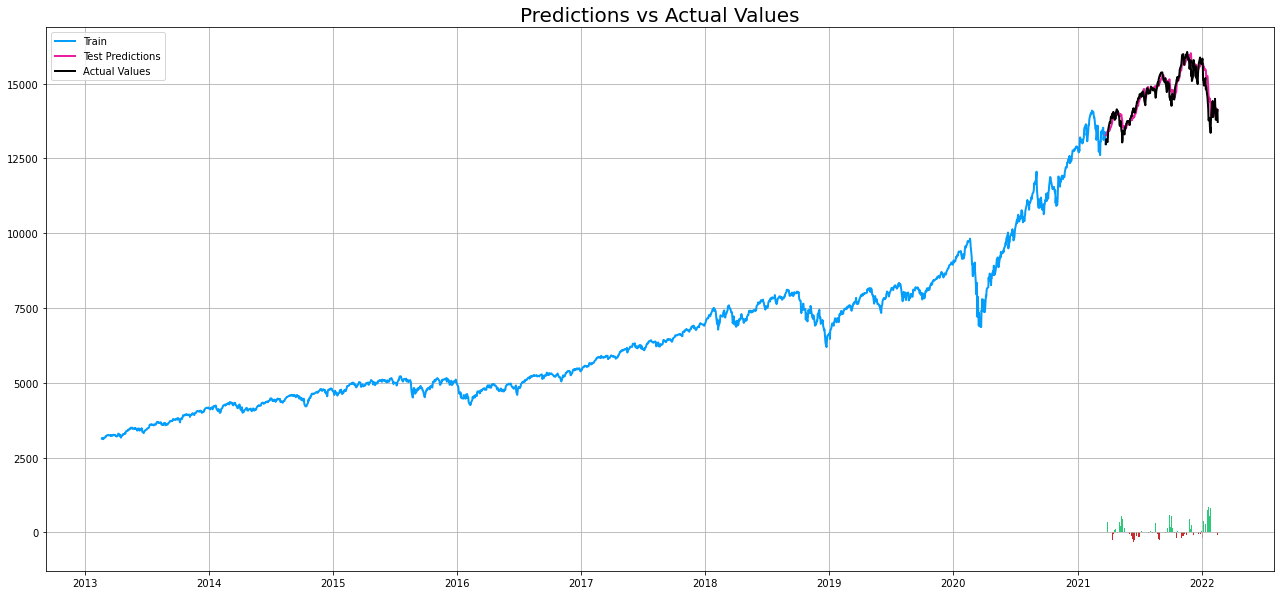

In [57]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["^IXIC_Close"]]
xv = valid['Date']; yv = valid[["^IXIC_Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
#plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt["^IXIC_Close"], color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["^IXIC_Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()